In [1]:
'-------------------------------- Load in regular libraries ------------------------------------'
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import os

In [2]:
'-------------------------------- Load in custom libraries ------------------------------------'
from src.Machine_Learning import DirectSolver
from src.Machine_Learning import Models
from src.Matrix_Properties import MatrixProperties
from src.Data import Data_Generation

In [4]:
'-------------------------------- Initialize custom classes ------------------------------------'
MAP  = MatrixProperties()
DS   = DirectSolver()
ML   = Models()
data = Data_Generation()

In [ ]:
" ---------------------------------------- Generate & Test Data ---------------------------------------------- "
# Implement additional columns:
multicolinearity_addition = True
superficial_addition      = False
data_mode                 = 'Linear Regression' #Classifier or Linear Regression

# Generate data:
match data_mode:
    case 'Linear Regression':
        X, w, y = data._data_generation_linear_regression(nrows = 300, ncols = 20, noise_addition = True)
    
    case 'Classifier':
        X, w, y = data._data_generation_classifier(nrows = 300, ncols = 20)

if multicolinearity_addition:
    # Addition of multicolinear columns:
    multicolinear_columns = data._multicolinearities_addition(X, N_multicolinear_columns = 200)
    X                     = np.hstack((X, multicolinear_columns))
    
if superficial_addition:
    superficial_columns   = data._superficial_addition(nrows = 300, ncols = 200)
    X                     = np.hstack((X, superficial_columns))
    
# Split data:
X_train, y_train, X_test, y_test = data._data_splitting(X = X, y = y, mode = 'ratio', nrows_train = 0.8)

# Compute condition number:
kappa = MAP._condition_number(np.matmul(X_train.transpose(), X_train))

# Compute rank:
rank = MAP._rank(np.matmul(X_train.transpose(), X_train))

In [ ]:
" ------------------------------------- Run Ordinary Least Squares ------------------------------------------- "
J_train, J_test = ML._ordinary_least_squares(X_train, X_test, y_train, y_test, print_statement = True)

In [ ]:
# Set matrix solver mode:
mode     = 'Cholesky'
method   = ['Ridge Regression', 'Hinge Loss Classification', 'Logistic Classification']

# Save fig:
save_fig  = True
fig_name  = 'machine_learning_output.png'
directory = 'img'

# Initialize lambda values:
lam_min = 0
lam_max = 1e2
N       = int(lam_max + 1)
lam_sim = np.linspace(lam_min, lam_max, N)

# Initialize figs:
fig, axs = plt.subplots(1, len(method), figsize = (20, 5))

for j in range(len(method)):
    
    # Initialize arrays:
    J_train_sim = np.zeros(N)
    J_test_sim  = np.zeros(N)

    # Run simulations:
    for i in range(N):

        match method[j]:
            case 'Ridge Regression':
                J_train, J_test = ML._ridge_regression(X_train, X_test, y_train, y_test, mode = mode, lam = lam_sim[i])

            case 'Hinge Loss Classification':
                J_train, J_test = ML._hinge_loss_classification(X_train, X_test, y_train, y_test, mode = mode, lam = lam_sim[i])

            case 'Logistic Classification':
                J_train, J_test = ML._logistic_classification(X_train, X_test, y_train, y_test, mode = mode, lam = lam_sim[i])

        J_train_sim[i]  = J_train
        J_test_sim[i]   = J_test

        if (N - i) % 10 == 0:
            clear_output(wait=True)
            print(f'Iterations remaining: {N - i}')

    # Visualize results:
    axs[j].plot(lam_sim, J_train_sim, label = '$J_{train}$', color = 'steelblue')
    axs[j].plot(lam_sim, J_test_sim, label = '$J_{test}$', color = 'firebrick')

    box = axs[j].get_position()
    axs[j].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axs[j].legend(loc='center left', bbox_to_anchor=(1, 0.75))

    axs[j].grid()
    axs[j].set_xlabel('$\lambda$')
    axs[j].set_ylabel('Loss function $J$')
    axs[j].set_title(f'{method[j]}: Loss function $J$ vs. $\lambda$')

if save_fig:
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    fig.savefig(directory + '/' + fig_name)

plt.show()

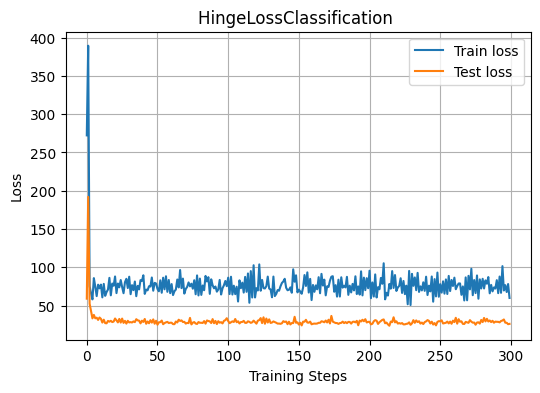

HingeLossClassification | Final Train Loss: 60.0602 | Final Test Loss: 26.2082


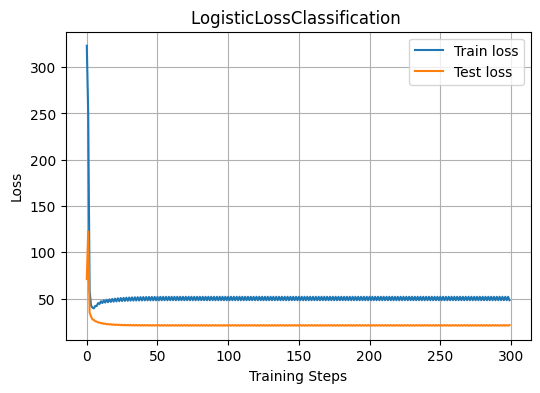

LogisticLossClassification | Final Train Loss: 48.2120 | Final Test Loss: 21.3662


In [6]:
from src.Machine_Learning import HingeLossClassification, LogisticLossClassification


dimension = 20
samples = 300
l = 0.3
lr = 0.1

X, _, y = data._data_generation_classifier(nrows=samples, ncols=dimension)

X_train, y_train, X_test, y_test = data._data_splitting(
    X=X, y=y, mode='ratio', nrows_train=0.8
)

train_steps = 300

hingeLoss = HingeLossClassification(dimension, l, lr)
logisticLoss = LogisticLossClassification(dimension, l, lr)  
losses = [hingeLoss, logisticLoss]

loss_history = [[] for _ in losses]
test_loss_history = [[] for _ in losses]

for step in range(train_steps):
    for i, loss_function in enumerate(losses):
        # compute test loss first (will set cache)
        test_loss = loss_function.forward(X_test, y_test)
        # compute train loss (overwrites cache to train data)
        loss = loss_function.forward(X_train, y_train)

        # compute gradients
        grad = loss_function.backward()     

        # apply optimization step  
        loss_function.step()

        loss_history[i].append(loss)
        test_loss_history[i].append(test_loss)

# plotting
for i, lf in enumerate(losses):
    plt.figure(figsize=(6,4))
    plt.plot(loss_history[i], label='Train loss')
    plt.plot(test_loss_history[i], label='Test loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'{type(lf).__name__} ')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"{type(lf).__name__} | Final Train Loss: {loss_history[i][-1]:.4f} | "
          f"Final Test Loss: {test_loss_history[i][-1]:.4f}")


